In [1]:
import numpy as np
import keras
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import cv2
import os

import carrega_imagens

## 1. Carregando as entradas (X) e saídas (y)

Criamos um script específico (*carrega_imagens.py*) para carregar e transformar as imagens em tensores, e que já faz a separação das entradas e saídas em treino (80%) e teste (20%). Especificamente neste notebook nós utilizaremos apenas o conjunto de dados referente a testes (para calcularmos as acurácias dos modelos).

In [2]:
X_train, X_test, y_train, y_test = carrega_imagens.load()
y_test_OH = to_categorical(y_test)

## 2. Carregando os modelos e escolhendo o melhor

Fazendo alguns testes alterando parâmetros e a estrutura da CNN do notebook "1.treinando_o_modelo.ipynb", treinamos e salvamos em disco dois modelos, que carregamos abaixo:

In [3]:
CNN_model_v10 = keras.models.load_model('modelo-cnn-v10')
CNN_model_v20 = keras.models.load_model('modelo-cnn-v20')

Abaixo calculamos a acurácia de cada modelo para os dados de testes, para escolhermos o de melhor desempenho:

In [4]:
print("Acurácia de cada modelo:")
print(f'modelo-cnn-v10: {CNN_model_v10.evaluate(X_test, y_test_OH, batch_size=32)[1]*100:.2f}%')
print(f'modelo-cnn-v20: {CNN_model_v20.evaluate(X_test, y_test_OH, batch_size=32)[1]*100:.2f}%')

Acurácia de cada modelo:
32/32 [==============================] - 25s 766ms/step - loss: 19.2600 - accuracy: 0.9800
modelo-cnn-v10: 98.00%
32/32 [==============================] - 23s 709ms/step - loss: 0.0690 - accuracy: 0.9910
modelo-cnn-v20: 99.10%


Como vimos, o modelo **CNN_model_v20** apresentou uma leve vantagem na acurácia, por isso vamor utilizá-lo de agora em diante.

## 3. Confusion Matrix

A fim de termos um retrato melhor de como está o desempenho do nosso modelo, iremos criar uma matriz de confusão. Assim conseguiremos identificar, se for o caso, quais dígitos são mais difíceis de classificar, e assim poder melhorar o dataset de treino.
Já temos o vetor de labels reais do set de teste (y_test), porém precimos obter o vetor de labels preditos (y_pred):

In [5]:
y_pred_probs = CNN_model_v20.predict(X_test)

Acima nós calculamos as probabilidades de cada entrada do tensor X_test representar cada dígito, ou seja, y_pred_probs contém agora 10 probabilidades (representando os dígitos de 0 a 9) para cada entrada. Abaixo nós verificamos qual é a maior probabilidade de cada entrada, pois esta será a previsão do modelo:

In [6]:
y_pred = []
for probs in y_pred_probs:
    max_prob = np.max(probs)
    digito = np.where(probs == max_prob)[0][0]
    y_pred.append(digito)

Por fim plotamos a matriz de confusão, para verifiar quais previsões o modelo errou:

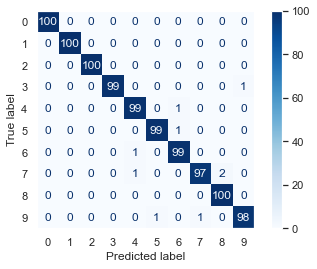

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Como podemos ver na matriz de confusão acima, os erros estão quase que uniformemente distribuídos, o que mostra um modelo bastante consistente. Talvez os dígitos 7 e 9 sejam os mais problemáticos para classificar, porém não podemos concluir isso agora com esse pequeno número de erros. 

## 4. Classificando fotos inéditas

Vimos que a acurácia para a base de dados de testes foi superior a 99%, porém agora vamos fazer um teste com o modelo com imagens que não fazem parte do dataset original, ou seja, não seguem "padrão" das fotos do dataset. Isso vai mostrar se nosso modelo está robusto ou não.
Para fazermos isso escolhemos 10 fotos inéditas (retiradas da internet), que representam os dígitos de 0 a 9, e colocamos na pasta 'meus_sinais'. Abaixo carregamos essas imagens, transformamos em preto&branco e mostramos:

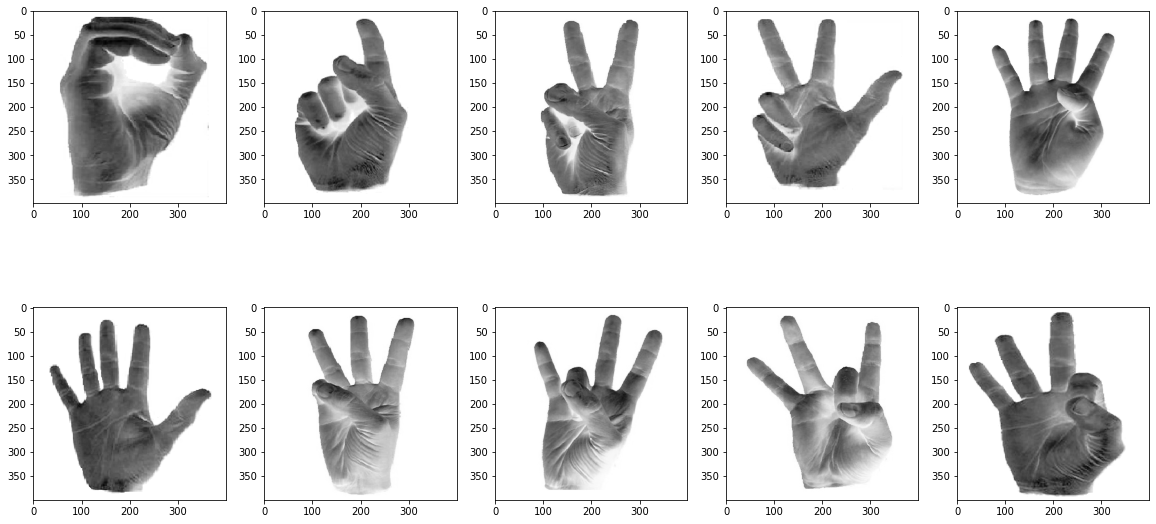

In [11]:
sns.reset_orig()
fig, axarr = plt.subplots(2,5)
fig.set_size_inches(20, 10)

imagens = []
for i in range(0,10):
    img = cv2.imread(os.path.join('meus_sinais', str(i) +'.png'), cv2.IMREAD_GRAYSCALE)
    imagens.append(img)
    linha = 0 if (i < 5) else 1
    col = i if (i < 5) else i - 5
    _ = axarr[linha, col].imshow(img, cmap='Greys')

plt.grid(False)
_ = plt.show()

Abaixo, finalmente, classificamos as 10 imagens utilizando o modelo desenvolvido, e mostramos na própria imagem qual é a previsão de cada foto, assim como o valor da propabilidade da previsão:

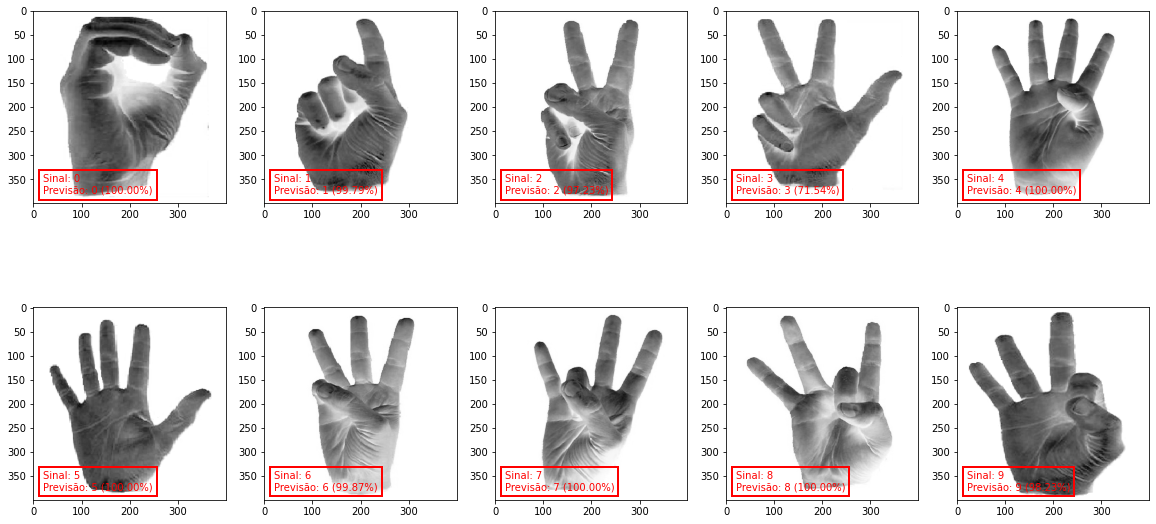

In [12]:
from turtle import color


previsoes = []
fig_num = 0

for img in imagens:
    new_img = img.reshape(1, 400, 400, 1)
    previsao = CNN_model_v20.predict(new_img)[0]
    maior_proba = previsao.max()
    numero = np.where(previsao == maior_proba)
    previsoes.append( (fig_num, numero[0][0], previsao[numero][0]) )
    
    fig_num += 1

fig, axarr = plt.subplots(2,5)
fig.set_size_inches(20, 10)

for i in range(0,10):
    linha = 0 if (i < 5) else 1
    col = i if (i < 5) else (i - 5)
    _ = axarr[linha, col].imshow(imagens[i], cmap='Greys')
    prob = "{:.2f}".format(previsoes[i][2]*100)
    texto = "Sinal: " + str(i) + "\nPrevisão: " + str(previsoes[i][1]) + " (" + prob + "%)"
    _ = axarr[linha, col].text(20, 380, texto, color='red', bbox=dict(fill=False, edgecolor='red', linewidth=2))
plt.show()

Como podemos ver, nosso modelo acertou todas as previsões, com ótimos percentuais. Logicamente que utilizamos fotos bastante parecidas com as do dataset, pois nosso dataset não é extenso o suficiente para que o modelo fosse extramamente robusto (o que exigiria centenas de milhares de imagens para treino).